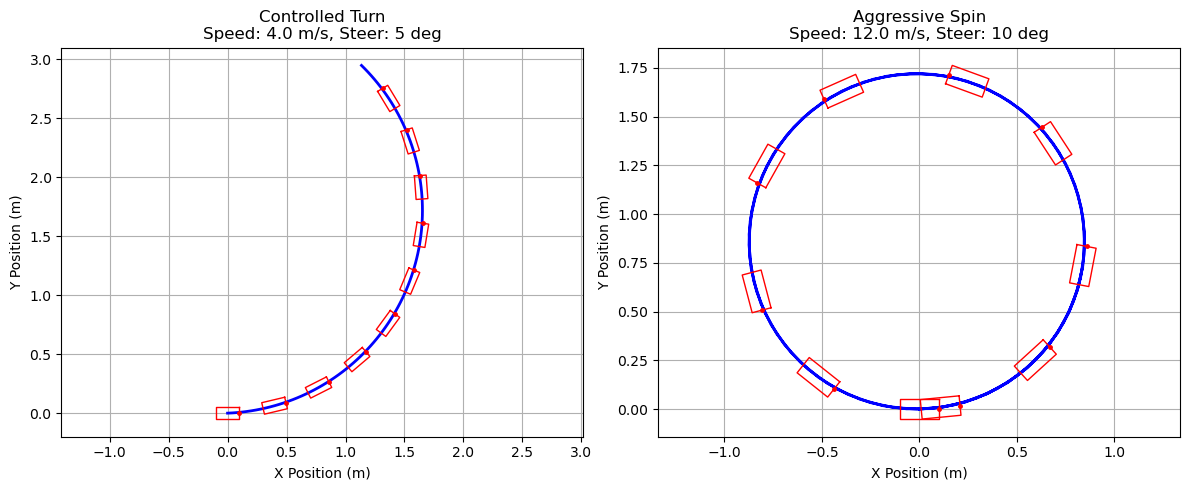

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def visualize_car_dynamics():
    # --- 1. Define Car Parameters ---
    m = 1.0          # Mass (kg)
    Iz = 0.004       # Yaw Inertia (kg m^2)
    lf = 0.075       # Front length (m)
    lr = 0.075       # Rear length (m)
    Cf = 2000.0      # Front Stiffness
    Cr = 2000.0      # Rear Stiffness

    # --- 2. Define Dynamics Function ---
    def vehicle_dynamics(state, t, v0, delta):
        # Unpack state: [Lateral Velocity, Yaw Rate, Global X, Global Y, Yaw Angle]
        vy, r, X, Y, psi = state
        
        # Matrix Calculation (Linear Bicycle Model)
        a11 = -(Cf + Cr) / (m * v0)
        a12 = ((lr * Cr - lf * Cf) / (m * v0)) - v0
        a21 = (lr * Cr - lf * Cf) / (Iz * v0)
        a22 = -(lf**2 * Cf + lr**2 * Cr) / (Iz * v0)
        b1 = Cf / m
        b2 = (lf * Cf) / Iz
        
        # State Derivatives (acceleration)
        vy_dot = a11 * vy + a12 * r + b1 * delta
        r_dot = a21 * vy + a22 * r + b2 * delta
        
        # Global Kinematics (How it moves on the map)
        # We rotate local velocities (v0, vy) into global map (X, Y)
        vx_global = v0 * np.cos(psi) - vy * np.sin(psi)
        vy_global = v0 * np.sin(psi) + vy * np.cos(psi)
        
        return [vy_dot, r_dot, vx_global, vy_global, r]

    # --- 3. Setup Simulation ---
    t = np.linspace(0, 1.0, 100) # Simulate for 1 second
    init_state = [0, 0, 0, 0, 0] # Start at rest (laterally) and at (0,0)

    # Condition 1: 4 m/s, 5 deg steer
    v1 = 4.0
    delta1 = np.radians(5)
    sol1 = odeint(vehicle_dynamics, init_state, t, args=(v1, delta1))

    # Condition 2: 12 m/s, 10 deg steer
    v2 = 12.0
    delta2 = np.radians(10)
    sol2 = odeint(vehicle_dynamics, init_state, t, args=(v2, delta2))

    # --- 4. Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Function to draw the trajectory with "Ghost" cars to show orientation
    def plot_trajectory(ax, solution, speed, steer, title):
        X = solution[:, 2]
        Y = solution[:, 3]
        Psi = solution[:, 4]
        
        # Plot Path
        ax.plot(X, Y, 'b-', linewidth=2, label='Path')
        
        # Draw "Car" rectangles every 10 steps to visualize Yaw vs Path
        for i in range(0, len(t), 10):
            x_pos = X[i]
            y_pos = Y[i]
            yaw = Psi[i]
            
            # Car Dimensions (1/18 scale approx)
            l = 0.2; w = 0.1
            
            # Rotate car body corners
            R = np.array([[np.cos(yaw), -np.sin(yaw)], [np.sin(yaw), np.cos(yaw)]])
            corners = np.array([[l/2, w/2], [l/2, -w/2], [-l/2, -w/2], [-l/2, w/2], [l/2, w/2]])
            rot_corners = (corners @ R.T) + [x_pos, y_pos]
            
            ax.plot(rot_corners[:,0], rot_corners[:,1], 'r-', linewidth=1)
            # Mark the front of the car
            front = (np.array([l/2, 0]) @ R.T) + [x_pos, y_pos]
            ax.plot(front[0], front[1], 'r.', markersize=5)

        ax.set_title(f"{title}\nSpeed: {speed} m/s, Steer: {steer} deg")
        ax.set_xlabel("X Position (m)")
        ax.set_ylabel("Y Position (m)")
        ax.axis('equal')
        ax.grid(True)

    plot_trajectory(axs[0], sol1, v1, 5, "Controlled Turn")
    plot_trajectory(axs[1], sol2, v2, 10, "Aggressive Spin")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_car_dynamics()

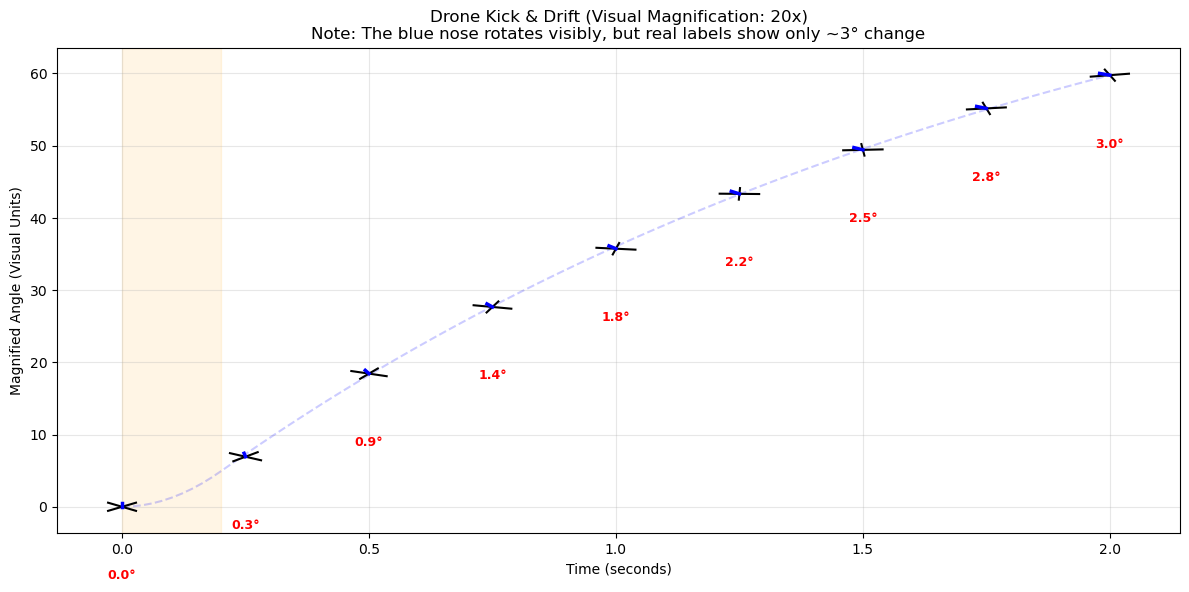

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def visualize_magnified_timeline():
    # --- 1. Define Parameters ---
    Iz = 0.09          
    dr = 0.05          
    torque_mag = 0.02  
    pulse_time = 0.2   

    # --- 2. Physics Model ---
    def drone_physics(state, t):
        psi = state[0] # Angle
        r = state[1]   # Rate
        tau = torque_mag if t <= pulse_time else 0.0
        r_dot = (tau - dr * r) / Iz
        psi_dot = r
        return [psi_dot, r_dot]

    # --- 3. Solve Dynamics ---
    t = np.linspace(0, 2.0, 100)
    sol = odeint(drone_physics, [0, 0], t)
    yaw_angles = sol[:, 0]

    # --- 4. Plotting with Magnification ---
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # MAGNIFICATION FACTOR: Scale angles by 20x so the eye can see the drift
    MAGNIFICATION = 20 
    
    degrees_real = np.degrees(yaw_angles)
    degrees_visual = degrees_real * MAGNIFICATION 
    
    # Plot the "Visual" curve
    ax.plot(t, degrees_visual, 'b--', alpha=0.2, label=f'Trajectory (Magnified {MAGNIFICATION}x)')

    # --- Draw Drone Snapshots ---
    snapshot_interval = 0.25 
    timestamps = np.arange(0, 2.1, snapshot_interval)
    
    for ts in timestamps:
        idx = (np.abs(t - ts)).argmin()
        
        # We use the MAGNIFIED angle for the drawing
        current_angle_visual = yaw_angles[idx] * MAGNIFICATION
        real_deg = degrees_real[idx] # We still print the REAL degrees text
        
        # Drone Geometry
        arm_len = 0.08
        base_angles = np.radians([45, 135, 225, 315])
        final_angles = base_angles + current_angle_visual
        
        # Center the drone on the curve
        center_x = ts
        center_y = degrees_visual[idx]
        
        # Arms
        x_arms = center_x + arm_len * np.cos(final_angles) * 0.5 
        y_arms = center_y + arm_len * np.sin(final_angles) * 10  
        
        ax.plot([x_arms[0], x_arms[2]], [y_arms[0], y_arms[2]], 'k-', linewidth=1.5)
        ax.plot([x_arms[1], x_arms[3]], [y_arms[1], y_arms[3]], 'k-', linewidth=1.5)
        
        # Blue Nose Indicator (The part you want to see move)
        nose_angle = current_angle_visual + np.pi/2
        nose_x = center_x + (arm_len*0.6) * np.cos(nose_angle) * 0.5
        nose_y = center_y + (arm_len*0.6) * np.sin(nose_angle) * 10
        ax.plot([center_x, nose_x], [center_y, nose_y], 'b-', linewidth=2.5) 
        
        # Real Data Label
        ax.text(center_x, center_y - 10, f"{real_deg:.1f}°", 
                ha='center', fontsize=9, color='red', fontweight='bold')

    ax.set_title(f"Drone Kick & Drift (Visual Magnification: {MAGNIFICATION}x)\nNote: The blue nose rotates visibly, but real labels show only ~3° change")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Magnified Angle (Visual Units)")
    ax.grid(True, alpha=0.3)
    ax.axvspan(0, 0.2, color='orange', alpha=0.1, label='Torque Pulse')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_magnified_timeline()